<a href="https://colab.research.google.com/github/rpdieego/Reinforcement_Learning/blob/master/Reinforcement_Learning_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Methods

#### Monte Carlo Policy Evaluation

In [0]:
#import relevant packages
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# definitions

#convergence parameter
conv_parameter = 10e-4

# discount factor
gamma = 0.9

# Action Space
ALL_POSSIBLE_ACTIONS = ('U','D','L','R')

In [0]:
#grid world class

class Grid: # Environment
  def __init__ (self, rows, cols, start):
    self.rows = rows
    self.cols = cols
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards is a dict of: (i,j): r
    # actions is a dict of: (i,j): A
    self.rewards = rewards
    self.actions = actions

  def set_state(self,s):
    #force state
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    #return the current state
    return (self.i, self.j)
  
  def is_terminal(self, s):
    #if state is not listed in the actions dictionary, it means it's a terminal state
    return s not in self.actions

  def get_next_state(self, s, a):
    i, j = s[0], s[1]
    if a in self.actions[(i,j)]:
      if a == 'U':
        i -= 1
      elif a =='D':
        i += 1
      elif a == 'R':
        j += 1
      elif a == 'L':
        j -= 1
    return i,j

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    #should never happen
    assert(self.current_state() in self.all_states())
  
  def game_over(self):
    #true if in a state where no actions are possible
    return (self.i,self.j) not in self.actions

  def all_states(self):
    #either a position that has possible next actions or a positions that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


In [0]:
# define grid environment

def standard_grid():
  g = Grid(3, 4, (2,0))
  rewards = {(0,3): 1, (1,3): -1}
  actions = {
      (0,0): ('D','R'),
      (0,1): ('L','R'),
      (0,2): ('L','D','R'),
      (1,0): ('U','D'),
      (1,2): ('U', 'D', 'R'),
      (2,0): ('U','R'),
      (2,1): ('L','R'),
      (2,2): ('L','R','U'),
      (2,3): ('L','U')
  }
  g.set(rewards, actions)
  return g

In [0]:
#define grid environment with step penalties

def negative_grid(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  g = standard_grid()
  g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
  })
  return g

In [0]:
# auxiliar function to print values
def print_values(V,g):
  for i in range(g.rows):
    print('-------------------------------')
    for j in range(g.cols):
      v = V.get((i,j),0)
      if v>= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # - sign take up an extra space
    print('')

In [0]:
# auxiliar function to print policy
def print_policy(P,g):
  print('Policy \n')
  for i in range(g.rows):
    print('-----------------------------')
    for j in range(g.cols):
      a = P.get((i,j),' ')
      print("  %s  |" % a, end='')
    print('')
  print('\n')


In [0]:
def play_game(grid, policy):

  #returns a list of states and corresponding returns

  #reset game to restart at random position
  #we need to do this, because given our current deterministic policy
  #we would never end up at certain states, but we still want to measure their value

  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  # list of tuples of (state, reward)
  states_and_rewards = [(s,0)]
  while not  grid.game_over():
    a = policy[s]
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s,r))

  #Calculate teh returns by working backwards from the terminal state
  G = 0
  states_and_returns = []
  first = True
  for s,r in reversed(states_and_rewards):
    # value of terminal state is 0 by definition
    #we should ignores the first state we encounter (terminal)
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_and_returns.append((s,G))
    
    G = r + gamma*G

  # we want it to be in order of state visited
  states_and_returns.reverse()

  return states_and_returns





In [9]:
### main

# use the standard grid again (0 for every step) so that we can compare 
# to the iterative policy evaluation

grid = standard_grid()

# print rewards
print('Rewards:')
print_values(grid.rewards, grid)
print('\n')

# state -> action
policy = {
    (2,0): 'U',
    (1,0): 'U',
    (0,0): 'R',
    (0,1): 'R',
    (0,2): 'R',
    (1,2): 'R',
    (2,1): 'R',
    (2,2): 'R',
    (2,3): 'U',
}

# initialize V(s) and returns
V = {}
#dictionary of state => list of returns we've recieved
returns = {}
states = grid.all_states()
for s in states:
  if s in grid.actions:
    returns[s] = []
  else:
    #terminal state or state we can't otherwise get to
    V[s] = 0

# repeat
for t in range(100):

  #generate an episode using pi
  states_and_returns = play_game(grid, policy)
  seen_states = set()
  for s, G in states_and_returns:
    # ' first visit ' MC policy evaluation
    # check if we already have seen s
    if s not in seen_states:
      returns[s].append(G)
      V[s] = np.mean(returns[s])
      seen_states.add(s)

print('Values:')
print_values(V,grid)
print('\n')
print('Policy:')
print_policy(policy,grid)
print('\n')




Rewards:
-------------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------------
 0.00| 0.00| 0.00| 0.00|


Values:
-------------------------------
 0.81| 0.90| 1.00| 0.00|
-------------------------------
 0.73| 0.00|-1.00| 0.00|
-------------------------------
 0.66|-0.81|-0.90|-1.00|


Policy:
Policy 

-----------------------------
  R  |  R  |  R  |     |
-----------------------------
  U  |     |  R  |     |
-----------------------------
  U  |  R  |  R  |  U  |






#### Monte Carlo Policy Evaluation in the Grid World


In [0]:
def random_action(a):
  #choose given a with probability 0.5
  #choose some other a' != with probability 0.5/3
  p = np.random.random()
  if p < 0.5:
    return a
  else:
    tmp = list(ALL_POSSIBLE_ACTIONS)
    tmp.remove(a)
    return np.random.choice(tmp)

In [0]:
def play_game(grid, policy):

  #returns a list of states and corresponding returns

  #reset game to restart at random position
  #we need to do this, because given our current deterministic policy
  #we would never end up at certain states, but we still want to measure their value

  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  # list of tuples of (state, reward)
  states_and_rewards = [(s,0)]
  while not  grid.game_over():
    a = policy[s]
    # possibly choose another action
    a = random_action(a)
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s,r))

  #Calculate teh returns by working backwards from the terminal state
  G = 0
  states_and_returns = []
  first = True
  for s,r in reversed(states_and_rewards):
    # value of terminal state is 0 by definition
    #we should ignores the first state we encounter (terminal)
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_and_returns.append((s,G))
    
    G = r + gamma*G

  # we want it to be in order of state visited
  states_and_returns.reverse()

  return states_and_returns



In [12]:
### main

# use the standard grid again (0 for every step) so that we can compare 
# to the iterative policy evaluation

grid = standard_grid()

# print rewards
print('Rewards:')
print_values(grid.rewards, grid)
print('\n')

# state -> action
policy = {
    (2,0): 'U',
    (1,0): 'U',
    (0,0): 'R',
    (0,1): 'R',
    (0,2): 'R',
    (1,2): 'U',
    (2,1): 'L',
    (2,2): 'U',
    (2,3): 'L',
}

# initialize V(s) and returns
V = {}
#dictionary of state => list of returns we've recieved
returns = {}
states = grid.all_states()
for s in states:
  if s in grid.actions:
    returns[s] = []
  else:
    #terminal state or state we can't otherwise get to
    V[s] = 0

# repeat
for t in range(100):

  #generate an episode using pi
  states_and_returns = play_game(grid, policy)
  seen_states = set()
  for s, G in states_and_returns:
    # ' first visit ' MC policy evaluation
    # check if we already have seen s
    if s not in seen_states:
      returns[s].append(G)
      V[s] = np.mean(returns[s])
      seen_states.add(s)

print('Values:')
print_values(V,grid)
print('\n')
print('Policy:')
print_policy(policy,grid)
print('\n')


Rewards:
-------------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------------
 0.00| 0.00| 0.00| 0.00|


Values:
-------------------------------
 0.48| 0.59| 0.71| 0.00|
-------------------------------
 0.37| 0.00| 0.22| 0.00|
-------------------------------
 0.31| 0.13| 0.08|-0.25|


Policy:
Policy 

-----------------------------
  R  |  R  |  R  |     |
-----------------------------
  U  |     |  U  |     |
-----------------------------
  U  |  L  |  U  |  L  |






#### Monte Carlo Control Problem - Exploring Starts

In [0]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this if we have a deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  # this is called the "exploring starts" method
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  seen_states = set()
  seen_states.add(grid.current_state())
  num_steps = 0
  while True:
    r = grid.move(a)
    num_steps += 1
    s = grid.current_state()

    if s in seen_states:
      # hack so that we don't end up in an infinitely long episode
      # bumping into the wall repeatedly
      # if num_steps == 1 -> bumped into a wall and haven't moved anywhere
      #   reward = -10
      # else:
      #   reward = falls off by 1 / num_steps
      reward = -10. / num_steps
      states_actions_rewards.append((s, None, reward))
      break
    elif grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = policy[s]
      states_actions_rewards.append((s, a, r))
    seen_states.add(s)

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + gamma*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

In [0]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

rewards:
-------------------------------
-0.50|-0.50|-0.50| 1.00|
-------------------------------
-0.50| 0.00|-0.50|-1.00|
-------------------------------
-0.50|-0.50|-0.50|-0.50|


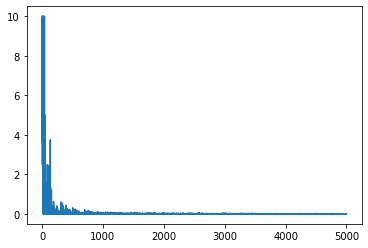

final policy:
Policy 

-----------------------------
  R  |  R  |  R  |     |
-----------------------------
  U  |     |  U  |     |
-----------------------------
  U  |  R  |  U  |  U  |


final values:
-------------------------------
-1.23|-0.71| 1.00| 0.00|
-------------------------------
-1.86| 0.00|-0.49| 0.00|
-------------------------------
-2.16|-1.93|-1.10|-1.00|


In [40]:
# use the standard grid again (0 for every step) so that we can compare
# to iterative policy evaluation
# grid = standard_grid()
# try the negative grid too, to see if agent will learn to go past the "bad spot"
# in order to minimize number of steps
grid = negative_grid(step_cost=-0.5)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

# state -> action
# initialize a random policy
policy = {}
for s in grid.actions.keys():
  policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

# initialize Q(s,a) and returns
Q = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
  if s in grid.actions: # not a terminal state
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0 # needs to be initialized to something so we can argmax it
      returns[(s,a)] = []
  else:
    # terminal state or state we can't otherwise get to
    pass

# repeat until convergence
deltas = []
for t in range(5000):

  # generate an episode using pi
  biggest_change = 0
  states_actions_returns = play_game(grid, policy)
  seen_state_action_pairs = set()
  for s, a, G in states_actions_returns:
    # check if we have already seen s
    # called "first-visit" MC policy evaluation
    sa = (s, a)
    if sa not in seen_state_action_pairs:
      old_q = Q[s][a]
      returns[sa].append(G)
      Q[s][a] = np.mean(returns[sa])
      biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
      seen_state_action_pairs.add(sa)
  deltas.append(biggest_change)

  # update policy
  for s in policy.keys():
    policy[s] = max_dict(Q[s])[0]

plt.plot(deltas)
plt.show()

print("final policy:")
print_policy(policy, grid)

# find V
V = {}
for s, Qs in Q.items():
  V[s] = max_dict(Q[s])[1]

print("final values:")
print_values(V, grid)

#### Monte Carlo Control Problem Without Exploring Starts

In [0]:
def random_action(a, eps=0.1):
  # choose given a with probability 1 - eps + eps/4
  # choose some other a' != a with probability eps/4
  p = np.random.random()
  # if p < (1 - eps + eps/len(ALL_POSSIBLE_ACTIONS)):
  #   return a
  # else:
  #   tmp = list(ALL_POSSIBLE_ACTIONS)
  #   tmp.remove(a)
  #   return np.random.choice(tmp)
  #
  # this is equivalent to the above
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [0]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns
  # in this version we will NOT use "exploring starts" method
  # instead we will explore using an epsilon-soft policy
  s = (2, 0)
  grid.set_state(s)
  a = random_action(policy[s])

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  while True:
    r = grid.move(a)
    s = grid.current_state()
    if grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = random_action(policy[s]) # the next state is stochastic
      states_actions_rewards.append((s, a, r))

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + gamma*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

rewards:
-------------------------------
-0.50|-0.50|-0.50| 1.00|
-------------------------------
-0.50| 0.00|-0.50|-1.00|
-------------------------------
-0.50|-0.50|-0.50|-0.50|


Initial Policy:
Policy 

-----------------------------
  U  |  D  |  U  |     |
-----------------------------
  L  |     |  U  |     |
-----------------------------
  D  |  L  |  L  |  L  |




0
1000
2000
3000
4000


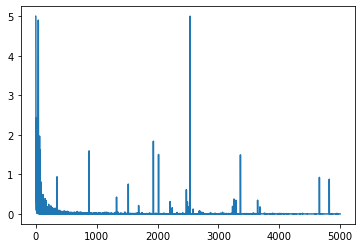

final values:
-------------------------------
-0.26| 0.32| 1.00| 0.00|
-------------------------------
-0.78| 0.00| 0.23| 0.00|
-------------------------------
-1.24|-1.70|-1.53|-1.00|
final policy:
Policy 

-----------------------------
  R  |  R  |  R  |     |
-----------------------------
  U  |     |  U  |     |
-----------------------------
  U  |  L  |  U  |  U  |




In [50]:
# use the standard grid again (0 for every step) so that we can compare
# to iterative policy evaluation
# grid = standard_grid()
# try the negative grid too, to see if agent will learn to go past the "bad spot"
# in order to minimize number of steps
grid = negative_grid(step_cost=-0.5)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)
print('\n')

# state -> action
# initialize a random policy
policy = {}
for s in grid.actions.keys():
  policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

print('Initial Policy:')
print_policy(policy, grid)
print('\n')


# initialize Q(s,a) and returns
Q = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
  if s in grid.actions: # not a terminal state
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0
      returns[(s,a)] = []
  else:
    # terminal state or state we can't otherwise get to
    pass

# repeat until convergence
deltas = []
for t in range(5000):
  if t % 1000 == 0:
    print(t)

  # generate an episode using pi
  biggest_change = 0
  states_actions_returns = play_game(grid, policy)

  # calculate Q(s,a)
  seen_state_action_pairs = set()
  for s, a, G in states_actions_returns:
    # check if we have already seen s
    # called "first-visit" MC policy evaluation
    sa = (s, a)
    if sa not in seen_state_action_pairs:
      old_q = Q[s][a]
      returns[sa].append(G)
      Q[s][a] = np.mean(returns[sa])
      biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
      seen_state_action_pairs.add(sa)
  deltas.append(biggest_change)

  # calculate new policy pi(s) = argmax[a]{ Q(s,a) }
  for s in policy.keys():
    a, _ = max_dict(Q[s])
    policy[s] = a

plt.plot(deltas)
plt.show()

# find the optimal state-value function
# V(s) = max[a]{ Q(s,a) }
V = {}
for s in policy.keys():
  V[s] = max_dict(Q[s])[1]

print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)